Machine Learning for Sentiment Analysis and Recommendation System

Team G42</br>
Janghyuk Boo, 40005573</br>
Mona Shayvard, 40061450

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import  word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from google.colab import drive
!pip install langdetect
import langdetect
from langdetect import detect
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

#drive.mount('/content/drive')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')


     |████████████████████████████████| 983kB 5.3MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=56ad5a680dc4ebf2a4e8f69afbda830d8583fbbd4bd3958293287379b90a535b
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:

df = pd.read_csv("7282_1.csv")

**Hotel Review data**

In [ ]:
df.head(5)
df[['address','categories','latitude','name','postalCode','reviews.date','reviews.rating','reviews.text' ]]

,address,categories,latitude,name,postalCode,reviews.date,reviews.rating,reviews.text
0,Riviera San Nicol 11/a,Hotels,45.421611,Hotel Russo Palace,30126,2013-09-22T00:00:00Z,4.0,Pleasant 10 min walk along the sea front to th...
1,Riviera San Nicol 11/a,Hotels,45.421611,Hotel Russo Palace,30126,2015-04-03T00:00:00Z,5.0,Really lovely hotel. Stayed on the very top fl...
2,Riviera San Nicol 11/a,Hotels,45.421611,Hotel Russo Palace,30126,2014-05-13T00:00:00Z,5.0,Ett mycket bra hotell. Det som drog ner betyge...
3,Riviera San Nicol 11/a,Hotels,45.421611,Hotel Russo Palace,30126,2013-10-27T00:00:00Z,5.0,We stayed here for four nights in October. The...
4,Riviera San Nicol 11/a,Hotels,45.421611,Hotel Russo Palace,30126,2015-03-05T00:00:00Z,5.0,We stayed here for four nights in October. The...
...,...,...,...,...,...,...,...,...
35907,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",35.754868,Elk Springs Resort,37738,2012-03-20T00:00:00Z,5.0,Best of the Best!!!! My family and I stayed in...
35908,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",35.754868,Elk Springs Resort,37738,2012-03-12T00:00:00Z,5.0,Amazing Vacation in Beautiful Cabin We stayed ...
35909,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",35.754868,Elk Springs Resort,37738,2015-11-03T00:00:00Z,5.0,My husband and I stayed at Tree Tops which is ...
35910,3747 29th St S E,"Hotels-Apartment,Corporate Lodging,Hotels,Lodging",42.909480,Extended Stay America Grand Rapids - Kentwood,49512,NaN,0.0,to share your opinion of this businesswith YP ...


# ***Data Preprocessing***
**Removing Non English review**

In [ ]:
df.dropna(subset=['reviews.text'],inplace=True)
df['reviews.text'].isnull().sum()

def addLang(text):
  try:
    language = detect(text)
  except:
    language = "error"
    print("This row throws and error:", text)
  return language

df['lang'] = df['reviews.text'].apply(lambda row: addLang(row))
dfNew = df[df['lang']!= 'error']
print(len(dfNew[dfNew['lang']== 'en']))

This row throws and error: . .
This row throws and error: . .
This row throws and error: , , , . , , 1 ! , .
This row throws and error: .....................................................................................
This row throws and error: !!!!!!!!!!!!!!!!
This row throws and error: !!!!!!!!!!!!!!!!
This row throws and error: !!!!!!!!!!!!!!!!
This row throws and error: , . , . .
This row throws and error: 10
This row throws and error: 10
This row throws and error: 2()
This row throws and error: , - - . , - .
This row throws and error: 26 -29. - 1 , . , - . . . , .
This row throws and error: . , . .
This row throws and error: ! , ! .
This row throws and error: https://www.daybreakhotels.com/it-it/italia/trezzano-sul-naviglio/best-western-hotel-goldenmile
This row throws and error: .
This row throws and error: () ( 2) ...
This row throws and error: . .
This row throws and error: !
This row throws and error: !
This row throws and error: , , , . . : , 2 - , , , . - 152 . - ) - , !

In [ ]:
dfNew = dfNew[dfNew['lang']== 'en']
dfNew['reviews.text'].head(2)

0    Pleasant 10 min walk along the sea front to th...
1    Really lovely hotel. Stayed on the very top fl...
Name: reviews.text, dtype: object

**Removing Stopwords and Tokenizer**

In [ ]:
stopWords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer() 
def preprocess(text): #we can add to this 
  #text = re.sub('.|,', ' ', text)
  tokenized = nltk.word_tokenize(text.lower())
  removedStopWords = [w for w in tokenized if w not in stopWords]
  puncRemoved = [w for w in removedStopWords if w.isalpha()]
  lemmatized = [lemmatizer.lemmatize(w) for w in puncRemoved]
  return lemmatized
  
dfNew['preprocessed'] = dfNew['reviews.text'].apply(lambda text: preprocess(text))

In [ ]:
dfNew.columns

Index(['address', 'categories', 'city', 'country', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateAdded',
       'reviews.doRecommend', 'reviews.id', 'reviews.rating', 'reviews.text',
       'reviews.title', 'reviews.userCity', 'reviews.username',
       'reviews.userProvince', 'lang', 'preprocessed'],
      dtype='object')

**Processing date format & review rate**

In [ ]:
dfNew = dfNew[dfNew['reviews.rating']	 < 6]
dfNew['reviews.rating'] = dfNew['reviews.rating'].astype(int)
positive = dfNew[dfNew['reviews.rating']>=4]
negative = dfNew[dfNew['reviews.rating']<2]
new = dfNew["reviews.date"].str.split("-", n = 1, expand = True) 
  
# making separate date column from new data frame 
dfNew["year"]= new[0] 
dfNew["Month"]= (new[1].str)[0:2]
dfNew["time"]= (new[1].str)[6:11]
dfNew=dfNew.drop(['reviews.date'], axis=1)
dfNew.head(2)

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince,lang,preprocessed,year,Month,time
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2016-10-24T00:00:25Z,NaN,NaN,4,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN,en,"[pleasant, min, walk, along, sea, front, water...",2013,09,00:00
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2016-10-24T00:00:25Z,NaN,NaN,5,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN,en,"[really, lovely, hotel, stayed, top, floor, su...",2015,04,00:00


**Review Rate**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



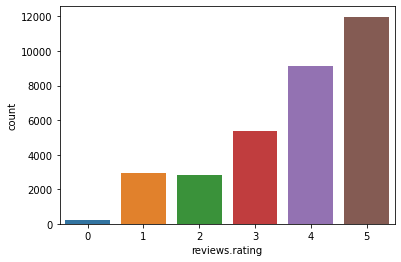

In [ ]:
sns.countplot(dfNew['reviews.rating'], label ='Count')

In [ ]:
dfNew[['preprocessed']].head(2)

,preprocessed
0,"[pleasant, min, walk, along, sea, front, water..."
1,"[really, lovely, hotel, stayed, top, floor, su..."


**Data Scaling**

In [ ]:
#Reduced the size of data 
newdf=dfNew[['name','reviews.rating','reviews.text','preprocessed']]
newdf['feedback'] = None
newdf.drop(newdf.index[10000:], inplace=True)
newdf.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,name,reviews.rating,reviews.text,preprocessed,feedback
0,Hotel Russo Palace,4,Pleasant 10 min walk along the sea front to th...,"[pleasant, min, walk, along, sea, front, water...",None
1,Hotel Russo Palace,5,Really lovely hotel. Stayed on the very top fl...,"[really, lovely, hotel, stayed, top, floor, su...",None


In [ ]:
newdf['feedback'].values[newdf['reviews.rating'].values ==5] = 1
newdf['feedback'].values[newdf['reviews.rating'].values <3] = 0
newdf=newdf.dropna()

In [ ]:
newdf['posTag'] = newdf.apply(lambda row: nltk.pos_tag(row['preprocessed']), axis=1)
newdf['posTag'].head(2)

1    [(really, RB), (lovely, JJ), (hotel, NN), (sta...
3    [(stayed, VBN), (four, CD), (night, NN), (octo...
Name: posTag, dtype: object

**Filter Adjectives**

In [ ]:
def keepAdj(txt):
    newText =[]
    for word in txt:
        if word[1] in ('JJ','JJS','JJR'):
            newText.append(word[0])
    return newText
newdf['keepAdj'] = newdf['posTag'].apply(keepAdj)
newdf['keepAdj'].head(2)

1    [lovely, top, jacuzzi, helpful, great, great, ...
3    [friendly, helpful, clean, good, light, wide, ...
Name: keepAdj, dtype: object

**Convert categorical variable into indicator variables**

In [ ]:
variation_dummies = pd.get_dummies(newdf['name'], drop_first = True) 
variation_dummies.head(2)

,Advance Motel,Alpine Motel,Alyssa's Motel,Ambassadors Inn and Suites,American Star Inn and Suites Atlantic City,Americana Resort Properties,Americas Best Value Inn,Americinn Coralville,Americinn Lodge Suites Austin,Americinn Lodge Suites Oscoda - Ausable River,Americinn Lodge and Suites,Amisos Hotel,Arcola Inn,Astro Motel,Azul Beach Hotel By Karisma Gourmet Inclusive,Barber Joyce,Baymont Inn & Suites Griffin,Baymont Inn and Suites Enid,Bent Elbow,Berkshire By The Sea A Vri Resort,Berney Fly Bed and Breakfast,Best Western Luxury Inn,Best Western Owasso Inn & Suites,Best Western Plus Arlington North Hotel and Suites,Best Western Plus French Quarter Landmark Hotel,Best Western Plus Waterville Grand Hotel,Big Mountain Lodge,Blue Top Inn,Body Tuneup,Boiling Springs Resort Canoe Rental,Briarcliff,Bridgetown Mill House Restaurant Inn,Budget Host Inn,Budget Inn South,Cadillac Motel,Candlewood Suites Huntersville,Candlewood Suites Olathe,Candlewood Suites West Springfield,Centennial Bed and Breakfast,Chippewa Hotel,...,Super 8 Columbia Dwntwn Sc,Super 8 Dallas South,Super 8 Elko Nv,Super 8 Ithaca,Super 8 Kingston,Super 8 Longmont / Del Camino,Super 8 Manhattan Ks,Super 8 Pittsburgh/monroeville,Super 8 Worthington Minnesota,"The Alexandrian, Autograph Collection",The Amble Inn,The Bluffs Inn Suites,The Chestnut Boutique Hotel,"The Citizen Hotel, Autograph Collection",The Governor Hotel,The Grove Seaside Hotel,The Houstonian Hotel,The Inn @ St. Botolph,The Inn On Negley,The Kingsport Inn,The Kinney - Venice Beach,The Litchfield Inn,The Miner's Inn Motel Restaurant,The National Conference Center,The Point,The White House Inn,Town Country Motel,Travelodge,Travelodge Shakopee,Truckee Tahoe Htl Larkspur,Tryp Dusseldorf Krefeld Hotel,Tulip Inn Turin West,Unionport Lodge No 333 F A M,Village Lodge,Vista Hotel On Lake Tarpon,Warwick Denver,White Cliff Manor Bed and Breakfast,Wine Valley Lodge,Wyndham Resort At Fairfield Mountains,Wyndham Vacation Resorts Towers On The Grove
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Convert Y-target to categorical variable**

In [ ]:
from keras.utils import to_categorical
target=newdf['reviews.rating'].values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

newdf = pd.concat([newdf, variation_dummies], axis=1)

y_target


array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

**Convert Tuple to String**

In [ ]:
def converTupleStr(tup):
  return ' '.join(tup)
newdf['preprocessedStr'] = newdf['preprocessed'].apply(lambda row: converTupleStr(row) )
newdf['newPreprocessed'] = newdf['preprocessed'].apply(lambda row: converTupleStr(row) )
newdf['newPreprocessed'].head(2) # we can use thise instead of preproceesdStr

1    really lovely hotel stayed top floor surprised...
3    stayed four night october hotel staff welcomin...
Name: newPreprocessed, dtype: object

In [ ]:
## Defining this datafram to use later in the recommendation system 
conRecomDf = newdf.groupby(['name'], as_index = False).agg({'preprocessedStr': ' '.join})
conRecomDf.head(2)

,name,preprocessedStr
0,Adria Motor Inn,share opinion businesswith yp visitor across u...
1,Advance Motel,one word horrible lol worst owner ever complet...


In [ ]:
newdf.drop(['name'], axis=1, inplace=True)


**Vectorizing vocabulary**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
newdf_countvectorizer = vectorizer.fit_transform(newdf['newPreprocessed']) # The text has to be cleaned first.
newdf_countvectorizer.shape
print(vectorizer.get_feature_names())
print(len(vectorizer.get_feature_names()))

['aa', 'aaa', 'aarp', 'aback', 'abandon', 'abandoned', 'abbott', 'abc', 'aberdeen', 'ability', 'able', 'aboard', 'abound', 'abounds', 'absence', 'absolute', 'absolutely', 'absorbent', 'abundant', 'abysmal', 'ac', 'acadia', 'accademia', 'accent', 'accept', 'acceptable', 'accepted', 'accepts', 'access', 'accessed', 'accessibility', 'accessible', 'accessing', 'accessory', 'accident', 'accidentally', 'accidently', 'accmodating', 'accomadating', 'accomadations', 'accomi', 'accomidate', 'accomidating', 'accommmodations', 'accommodate', 'accommodated', 'accommodating', 'accommodation', 'accomodate', 'accomodating', 'accomodation', 'accomodations', 'accompanied', 'accompanying', 'accomplished', 'accorded', 'according', 'accordingly', 'account', 'accroutrements', 'accurate', 'accusation', 'accustomed', 'ache', 'aching', 'achy', 'acidity', 'acknowledged', 'acomadation', 'acre', 'across', 'act', 'acted', 'acting', 'action', 'activating', 'active', 'actively', 'activity', 'actual', 'actually', 'ac

**Display TSNE**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all

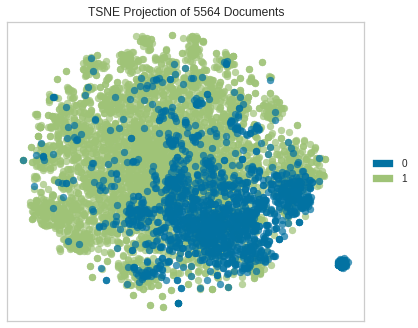

In [ ]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

data = newdf['newPreprocessed']
tfidf = TfidfVectorizer()
docs = tfidf.fit_transform(data)
labels = newdf['feedback']

tsne = TSNEVisualizer()
tsne.fit_transform(docs, labels)
tsne.poof() 
# show the distribution of negative and positive reviews 

In [ ]:

newdf.drop(['reviews.text'], axis=1, inplace=True) 
reviews = pd.DataFrame(newdf_countvectorizer.toarray())
newdf.head(1)

,reviews.rating,preprocessed,feedback,posTag,keepAdj,Advance Motel,Alpine Motel,Alyssa's Motel,Ambassadors Inn and Suites,American Star Inn and Suites Atlantic City,Americana Resort Properties,Americas Best Value Inn,Americinn Coralville,Americinn Lodge Suites Austin,Americinn Lodge Suites Oscoda - Ausable River,Americinn Lodge and Suites,Amisos Hotel,Arcola Inn,Astro Motel,Azul Beach Hotel By Karisma Gourmet Inclusive,Barber Joyce,Baymont Inn & Suites Griffin,Baymont Inn and Suites Enid,Bent Elbow,Berkshire By The Sea A Vri Resort,Berney Fly Bed and Breakfast,Best Western Luxury Inn,Best Western Owasso Inn & Suites,Best Western Plus Arlington North Hotel and Suites,Best Western Plus French Quarter Landmark Hotel,Best Western Plus Waterville Grand Hotel,Big Mountain Lodge,Blue Top Inn,Body Tuneup,Boiling Springs Resort Canoe Rental,Briarcliff,Bridgetown Mill House Restaurant Inn,Budget Host Inn,Budget Inn South,Cadillac Motel,...,Super 8 Elko Nv,Super 8 Ithaca,Super 8 Kingston,Super 8 Longmont / Del Camino,Super 8 Manhattan Ks,Super 8 Pittsburgh/monroeville,Super 8 Worthington Minnesota,"The Alexandrian, Autograph Collection",The Amble Inn,The Bluffs Inn Suites,The Chestnut Boutique Hotel,"The Citizen Hotel, Autograph Collection",The Governor Hotel,The Grove Seaside Hotel,The Houstonian Hotel,The Inn @ St. Botolph,The Inn On Negley,The Kingsport Inn,The Kinney - Venice Beach,The Litchfield Inn,The Miner's Inn Motel Restaurant,The National Conference Center,The Point,The White House Inn,Town Country Motel,Travelodge,Travelodge Shakopee,Truckee Tahoe Htl Larkspur,Tryp Dusseldorf Krefeld Hotel,Tulip Inn Turin West,Unionport Lodge No 333 F A M,Village Lodge,Vista Hotel On Lake Tarpon,Warwick Denver,White Cliff Manor Bed and Breakfast,Wine Valley Lodge,Wyndham Resort At Fairfield Mountains,Wyndham Vacation Resorts Towers On The Grove,preprocessedStr,newPreprocessed
1,5,"[really, lovely, hotel, stayed, top, floor, su...",1,"[(really, RB), (lovely, JJ), (hotel, NN), (sta...","[lovely, top, jacuzzi, helpful, great, great, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,really lovely hotel stayed top floor surprised...,really lovely hotel stayed top floor surprised...


**Set Feature X and Target Y**

In [ ]:
newdf.reset_index(drop=True, inplace=True)
newdf = pd.concat([newdf, reviews], axis=1)
X = newdf.drop(['reviews.rating','feedback','preprocessed','preprocessedStr','preprocessedStr','newPreprocessed','keepAdj','posTag'],axis=1)
y = newdf['feedback']

*Split Test & Train Set*

In [ ]:
X = np.asarray(X).astype(np.float32) #fixed type to float as tensor doesn't allow int
y = np.asarray(y).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=5)

**Model 1 : Neural Network_V1**

> *This model predicts binary value either Positive or Negative*



In [ ]:
import tensorflow_addons as tfa


ANN_classifier = tf.keras.models.Sequential()
#2 layers are used. relu= rectified  something
ANN_classifier.add(tf.keras.layers.Dense(units=400, activation='relu', input_shape=(X_train.shape[1] ,   )))
#Change input shape when needed.
ANN_classifier.add(tf.keras.layers.Dense(units=400, activation='relu'))
##sigmoid 0 or 1, can we imporeve it as percentage instead?
ANN_classifier.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ANN_classifier.summary()
ANN_classifier.compile(optimizer='Adam', loss='binary_crossentropy',metrics=[tfa.metrics.F1Score(num_classes=2, average="micro")])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               3506400   
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 3,667,201
Trainable params: 3,667,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs_hist = ANN_classifier.fit(X_train, y_train, epochs = 10)

Epoch 1/10
140/140 [==============================] - 3s 24ms/step - loss: 0.2826 - f1_score: 0.8248
Epoch 2/10
140/140 [==============================] - 3s 25ms/step - loss: 0.0872 - f1_score: 0.8248
Epoch 3/10
140/140 [==============================] - 3s 24ms/step - loss: 0.0361 - f1_score: 0.8255
Epoch 4/10
140/140 [==============================] - 3s 25ms/step - loss: 0.0192 - f1_score: 0.8265
Epoch 5/10
140/140 [==============================] - 3s 24ms/step - loss: 0.0103 - f1_score: 0.8282
Epoch 6/10
140/140 [==============================] - 3s 25ms/step - loss: 0.0069 - f1_score: 0.8290
Epoch 7/10
140/140 [==============================] - 3s 25ms/step - loss: 0.0064 - f1_score: 0.8320
Epoch 8/10
140/140 [==============================] - 4s 25ms/step - loss: 0.0063 - f1_score: 0.8337
Epoch 9/10
140/140 [==============================] - 4s 25ms/step - loss: 0.0058 - f1_score: 0.8350
Epoch 10/10
140/140 [==============================] - 3s 24ms/step - loss: 0.0057 - f1_sco

**Learning Curve for each epoch**

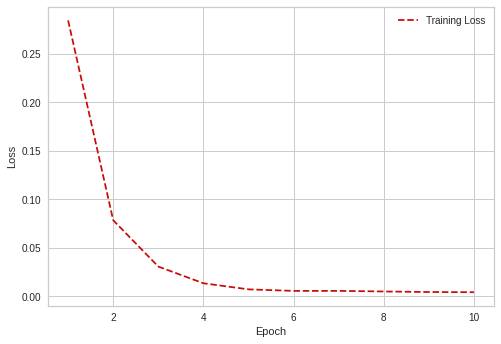

In [ ]:

# Create count of the number of epochs
epoch_count = range(1, len(epochs_hist.history['loss']) + 1)
# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, epochs_hist.history['loss'], 'r--')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

**Accuracy & Loss on Test Set**

In [ ]:
ANN_classifier.evaluate(X_test, y_test)

35/35 [==============================] - 0s 8ms/step - loss: 0.6831 - accuracy: 0.9013


[0.6830697655677795, 0.9012567400932312]

**Model 1 : Neural Network_V2**

> *This model predicts sentimental score from 1-5*



In [ ]:
#seconds types of data splitting to get score 0-5

X_train2, X_test2, y_train2, y_test2=train_test_split(X,y_target,test_size=0.2,stratify=y_target)

ANN_classifier = tf.keras.models.Sequential()
#2 layers are used. relu= rectified  something
ANN_classifier.add(tf.keras.layers.Dense(units=400, activation='relu', input_shape=(X_train.shape[1], )))
ANN_classifier.add(tf.keras.layers.Dense(units=400, activation='relu'))
##sigmoid 0 or 1, can we imporeve it as percentage instead?
ANN_classifier.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
ANN_classifier.summary()
ANN_classifier.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])
epochs_hist = ANN_classifier.fit(X_train2, y_train2, epochs = 10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 400)               3506800   
_________________________________________________________________
dense_4 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 2406      
Total params: 3,669,606
Trainable params: 3,669,606
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
140/140 [==============================] - 3s 24ms/step - loss: 0.1646 - accuracy: 0.7907
Epoch 2/10
140/140 [==============================] - 3s 24ms/step - loss: 0.0628 - accuracy: 0.9322
Epoch 3/10
140/140 [==============================] - 3s 24ms/step - loss: 0.0232 - accuracy: 0.9791
Epoch 4/10
140/140 [==============================] - 3s 24ms/step - lo

**Learning Curve for each epoch**

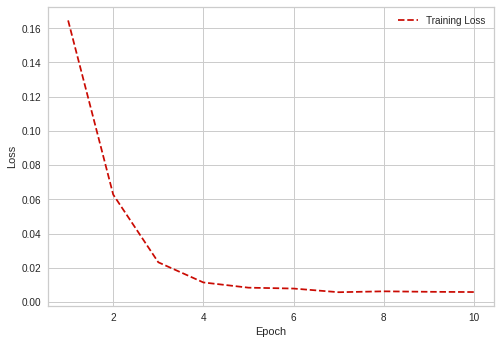

In [ ]:
# Create count of the number of epochs
epoch_count = range(1, len(epochs_hist.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, epochs_hist.history['loss'], 'r--')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

**Accuracy & Loss on Test Set**

In [ ]:
ANN_classifier.evaluate(X_test2, y_test2)

35/35 [==============================] - 0s 9ms/step - loss: 0.2870 - accuracy: 0.8232


[0.286994069814682, 0.8231598138809204]

In [ ]:
from tqdm import tqdm
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 4454/4454 [00:05<00:00, 851.15it/s]

11
8766


**RNN - LSTM**

In [ ]:
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

model=Sequential()
model.add(Embedding(len(list(unique_words)),50,input_length=len_max))
model.add(LSTM(16,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(8,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 8766, 50)          550       
_________________________________________________________________
lstm_2 (LSTM)                (None, 8766, 16)          4288      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               900       
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 606       
Total params: 7,144
Trainable params: 7,144
Non-trainable params: 0
____________________________________________________

In [ ]:
history=model.fit(X_train2, y_train2, epochs=6, batch_size=256, verbose=1, callbacks=callback)


Epoch 1/6
18/18 [==============================] - 750s 42s/step - loss: 1.2899 - accuracy: 0.6704
Epoch 2/6
18/18 [==============================] - 783s 44s/step - loss: 0.9167 - accuracy: 0.7025
Epoch 3/6
18/18 [==============================] - 785s 44s/step - loss: 0.8963 - accuracy: 0.7039
Epoch 4/6
18/18 [==============================] - 796s 44s/step - loss: 0.8819 - accuracy: 0.7039
Epoch 5/6
18/18 [==============================] - 806s 45s/step - loss: 0.8805 - accuracy: 0.7039
Epoch 6/6
18/18 [==============================] - 797s 44s/step - loss: 0.8800 - accuracy: 0.7039


**CNN**

In [ ]:
from keras.layers import Conv1D, Conv2D, Convolution1D, MaxPooling1D, SeparableConv1D, SpatialDropout1D, \
    GlobalAvgPool1D, GlobalMaxPool1D, GlobalMaxPooling1D 
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten
model = Sequential()
model.add(Embedding(len(list(unique_words)),50,input_length=len_max))
model.add(Conv1D(16, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())


model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2048, activation='relu'))

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8766, 50)          550       
_________________________________________________________________
conv1d (Conv1D)              (None, 8764, 16)          2416      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)             

In [ ]:
history=model.fit(X_train2, y_train2, epochs=6, batch_size=256, verbose=1, callbacks=callback)


Epoch 1/6
18/18 [==============================] - 39s 2s/step - loss: 2.0837 - accuracy: 0.4490
Epoch 2/6
18/18 [==============================] - 40s 2s/step - loss: 1.3914 - accuracy: 0.6141
Epoch 3/6
18/18 [==============================] - 39s 2s/step - loss: 1.2585 - accuracy: 0.6489
Epoch 4/6
18/18 [==============================] - 39s 2s/step - loss: 1.2882 - accuracy: 0.6453
Epoch 5/6
18/18 [==============================] - 39s 2s/step - loss: 1.2297 - accuracy: 0.6753
Epoch 6/6
18/18 [==============================] - 39s 2s/step - loss: 1.1310 - accuracy: 0.6956


**Plot Confusion Matrix**

In [ ]:
from sklearn.metrics import plot_confusion_matrix

def plotMatrix(title, model, pred, y_test):
  labels = [0, 1]
  cm = confusion_matrix(y_test, pred, labels)
  print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the ' + title)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


In [ ]:
# separate test and train data 
X_train2, X_test2, y_train2, y_test2=train_test_split(X,y_target,test_size=0.2,stratify=y_target)


**Gaussian Naive Bayes**



[[15  1]
 [ 0 84]]


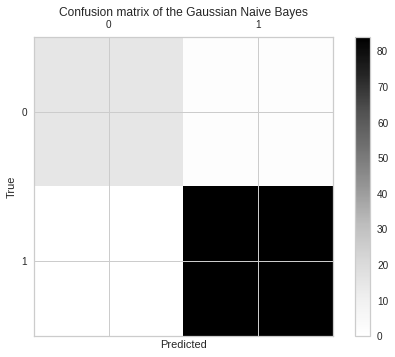

In [ ]:

gnb = GaussianNB()
gnb.fit(X_train2, np.argmax(y_train2,axis=1))
pred_gnb = gnb.predict(X_test2)
gnb.score(X_test2, np.argmax(y_test2,axis=1))
plotMatrix("Gaussian Naive Bayes",gnb, pred_gnb, np.argmax(y_test2,axis=1) )


**Model 2 : SVM**

In [ ]:
from sklearn import svm
svmModel = svm.SVC(kernel='linear')
svmModel.fit(X_train2, np.argmax(y_train2,axis=1))
svmPredict = svmModel.predict(X_test2)
svmModel.score(X_test2, np.argmax(y_test2,axis=1))

0.8078994614003591

[[14  0]
 [ 0 71]]


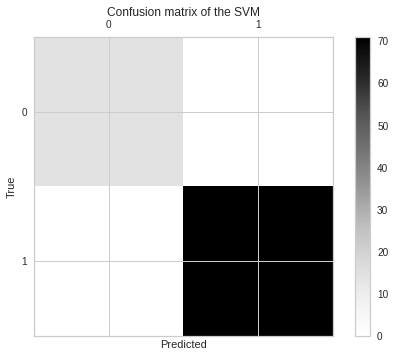

In [ ]:
plotMatrix("SVM",svmModel, svmPredict, np.argmax(y_test2,axis=1) )


**Model 3 : Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFModel = RandomForestClassifier(max_depth=10, random_state=1)
RFModel.fit(X_train2, np.argmax(y_train2,axis=1))
RFPredict = RFModel.predict(X_test2)
RFModel.score(X_test2, np.argmax(y_test2,axis=1))

0.718132854578097

[[12  0]
 [ 0  3]]


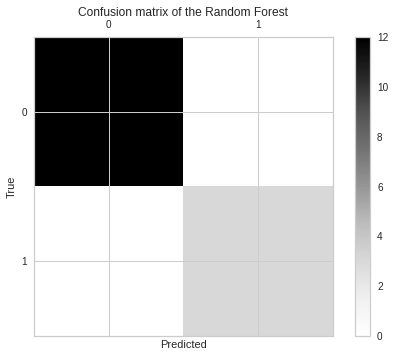

In [ ]:
plotMatrix("Random Forest",RFModel, RFPredict, np.argmax(y_test2,axis=1) )

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix = confusion_matrix(np.argmax(y_test2,axis=1), pred_gnb)
classification_report = classification_report(np.argmax(y_test2,axis=1), pred_gnb, output_dict=True)
classification_report

{'0': {'f1-score': 0.967741935483871,
  'precision': 1.0,
  'recall': 0.9375,
  'support': 16},
 '1': {'f1-score': 0.34285714285714286,
  'precision': 0.2441860465116279,
  'recall': 0.5753424657534246,
  'support': 146},
 '2': {'f1-score': 0.24778761061946902,
  'precision': 0.24561403508771928,
  'recall': 0.25,
  'support': 168},
 '5': {'f1-score': 0.7441520467836258,
  'precision': 0.8715753424657534,
  'recall': 0.6492346938775511,
  'support': 784},
 'accuracy': 0.5834829443447038,
 'macro avg': {'f1-score': 0.5756346839360271,
  'precision': 0.5903438560162751,
  'recall': 0.603019289907744,
  'support': 1114},
 'weighted avg': {'f1-score': 0.6199143061825119,
  'precision': 0.6967947838227874,
  'recall': 0.5834829443447038,
  'support': 1114}}

**Model 3 : Linear Regression**



> The idea is to apply simple linear regression to the dataset and then to check least square error. If the least square error shows high accuracy, it implies the dataset being linear in nature, else dataset is non-linear.



In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(X_train2, np.argmax(y_train2,axis=1))
# Checking the accuracy
from sklearn.metrics import r2_score
print(r2_score(regressor.predict(X_train2), np.argmax(y_train2,axis=1)))


0.9858293847553367


**Recommendation System**


> Calculation based on the IMDB formula



In [ ]:
#Recommendation System https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
c=dfNew['reviews.rating'].mean()
#dfNew['name','reviews.rating'].groupby('name').mean()
average_score=dfNew[['name','reviews.rating']].groupby('name').mean()
vote_count=dfNew[['name','reviews.rating']].groupby('name').count()
m=vote_count.quantile(0.5)
C=average_score.mean() #C is the mean vote across the whole report
def weighted_rating(x, m=m, C=C):
    v = x['Count_Vote']
    R = x['Avg_Rate']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)
m

reviews.rating    20.0
Name: 0.5, dtype: float64

**Calculating Score for Each Hotel**


> The higher the score, The higher the positiveness



In [ ]:
NewdataSet=dfNew[['city','name','reviews.rating']]
average_score=average_score.rename(columns={"reviews.rating": "Avg_Rate"})
vote_count=vote_count.rename(columns={"reviews.rating": "Count_Vote"})
Data=  pd.concat([average_score, vote_count], axis=1)
Data.reset_index(inplace=True)
Data['Count_Vote'] = np.asarray(Data['Count_Vote']).astype(np.float64)
#q_movies = [Data['Count_Vote'] >= m]
#q_movies
Data = Data[Data['Count_Vote']	 >=20]
Data['score'] = Data.apply(weighted_rating, axis=1)
Data

,name,Avg_Rate,Count_Vote,score
2,40 Berkeley Hostel,3.287671,146.0,3.264595
3,A Bed & Breakfast In Cambridge,3.680000,50.0,3.513182
4,Acorn Motor Inn,3.750000,20.0,3.423069
7,Agate Beach Motel,4.619048,21.0,3.876165
11,Ambassadors Inn and Suites,2.642857,98.0,2.719684
...,...,...,...,...
738,Wine Valley Lodge,4.015504,129.0,3.892099
739,Wingate By Wyndham Chantilly / Dulles Airport,4.310811,74.0,4.052370
740,Wingate By Wyndham Lagrange,4.390244,41.0,3.965947
741,Wingate By Wyndham Pueblo,4.423729,118.0,4.231324


**Filter the Score and Label Sentiment**


> Higher than 2 => Positive

> Less than 2 => Negative





In [ ]:
Data = Data.sort_values('score', ascending=False)
Data.head(10) #top 10 Demographic Filtering 
def f2(row):
    '''This function returns sentiment value based on the overall ratings from the user'''
    if row['Avg_Rate'] <2 :
        val = 'Negative'
    elif row['Avg_Rate'] > 4.0:
        val = 'Positive'
    elif row['Avg_Rate'] >2 or row['Avg_Rate']<4 :
        val = 'Neutral'
    else:
        val = -1
    return val
Data['sentiment'] = Data.apply(f2, axis=1)
Data

,name,Avg_Rate,Count_Vote,score,sentiment
126,Cliffrose Lodge Gardens,4.702532,158.0,4.522038,Positive
605,Simpson House Inn,4.741667,120.0,4.506591,Positive
270,Garden of The Gods Club & Resort,4.647059,170.0,4.483804,Positive
673,"The Alexandrian, Autograph Collection",4.474009,1135.0,4.450150,Positive
231,Excellence Riviera Cancun - Adults Only - All ...,4.873016,63.0,4.444853,Positive
...,...,...,...,...,...
218,Economy Inn,1.838710,31.0,2.331819,Negative
183,Days Inn Bowling Green,1.787879,33.0,2.281562,Negative
198,Days Inn and Suites Albany,2.036364,110.0,2.199406,Neutral
499,Norwood Inn and Suites,1.428571,63.0,1.830395,Negative



**Content Based Recommendation System**

The idea is to suggest similar items based on a particular item, here we used the cosine similarity on the reviews of the hotels and recommend the hotel based on the similarity of their reviews 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tfidf = TfidfVectorizer()

conRecomDf['preprocessedStr'] = conRecomDf['preprocessedStr'].fillna('')
tfidf_matrix = tfidf.fit_transform(conRecomDf['preprocessedStr'])

# Computing cosine similarity 
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(conRecomDf.index, index=conRecomDf['name']).drop_duplicates()



In [ ]:
# Function that takes in hotel title as input and outputs most similar hotels 
def get_recommendations(name, cosine_sim=cosine_sim):
    idx = indices[name]

    # pairwsie similarity scores 
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort based on the similarity scores and get 5 most scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    # get the indices 
    hotel_indices = [i[0] for i in sim_scores]

    return conRecomDf['name'].iloc[hotel_indices]

In [ ]:
get_recommendations('Ambassadors Inn and Suites')

174            Plaza Hotel and Casino - Las Vegas
26       Best Western Plus Waterville Grand Hotel
57                  Days Inn & Suites Castle Rock
71                                  Discovery Inn
5      American Star Inn and Suites Atlantic City
Name: name, dtype: object

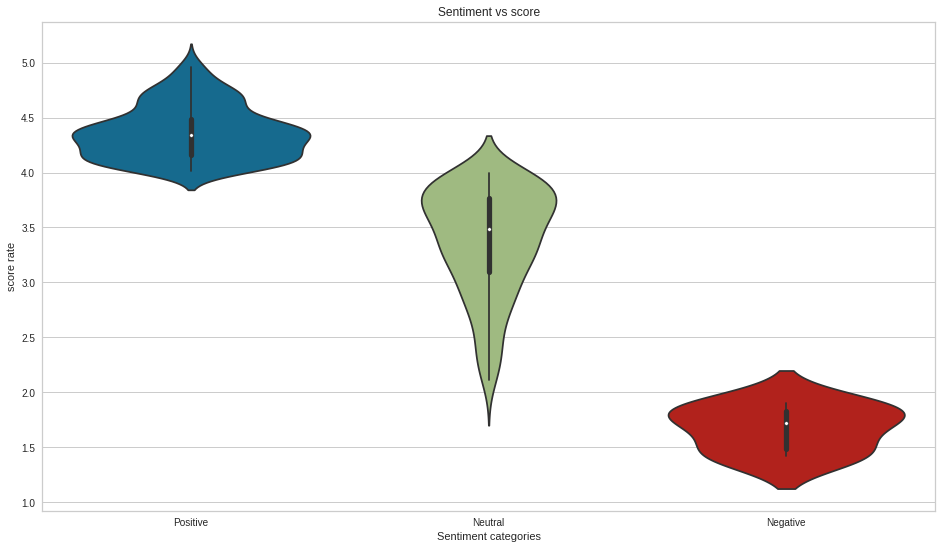

In [ ]:

%matplotlib inline

#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(Data, columns = ['sentiment', 'Avg_Rate'])
senti_help = senti_help[senti_help['Avg_Rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["sentiment"], y=senti_help["Avg_Rate"])
plt.title('Sentiment vs score')
plt.xlabel('Sentiment categories')
plt.ylabel('score rate')
plt.show()


In [ ]:
#plotting
data=dfNew[['city','name','reviews.rating','year','Month','time','preprocessed']]
data['preprocessed'] = data['preprocessed'].apply(lambda row: converTupleStr(row) )
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,city,name,reviews.rating,year,Month,time,preprocessed
0,Mableton,Hotel Russo Palace,4,2013,09,00:00,pleasant min walk along sea front water bus re...
1,Mableton,Hotel Russo Palace,5,2015,04,00:00,really lovely hotel stayed top floor surprised...
3,Mableton,Hotel Russo Palace,5,2013,10,00:00,stayed four night october hotel staff welcomin...
4,Mableton,Hotel Russo Palace,5,2015,03,00:00,stayed four night october hotel staff welcomin...
5,Mableton,Hotel Russo Palace,5,2015,04,00:00,loved staying island lido need take water veni...
...,...,...,...,...,...,...,...
35906,Gatlinburg,Elk Springs Resort,5,2016,05,00:00,time last weekend april stayed deer heart cabi...
35907,Gatlinburg,Elk Springs Resort,5,2012,03,00:00,best best family stayed grin bear cabin christ...
35908,Gatlinburg,Elk Springs Resort,5,2012,03,00:00,amazing vacation beautiful cabin stayed long w...
35909,Gatlinburg,Elk Springs Resort,5,2015,11,00:00,husband stayed tree top bearfoot resort manage...


In [ ]:
def f(row):
    '''This function returns sentiment value based on the overall ratings from the user'''
    if row['reviews.rating'] == 3.0:
        val = 'Neutral'
    elif row['reviews.rating'] == 1.0 or row['reviews.rating'] == 2.0:
        val = 'Negative'
    elif row['reviews.rating'] == 4.0 or row['reviews.rating'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [ ]:
data['reviews.rating'] = np.asarray(data['reviews.rating']).astype(np.float64)
data['sentiment'] = data.apply(f, axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data['sentiment'].value_counts()
data

,city,name,reviews.rating,year,Month,time,preprocessed,sentiment
0,Mableton,Hotel Russo Palace,4.0,2013,09,00:00,pleasant min walk along sea front water bus re...,Positive
1,Mableton,Hotel Russo Palace,5.0,2015,04,00:00,really lovely hotel stayed top floor surprised...,Positive
3,Mableton,Hotel Russo Palace,5.0,2013,10,00:00,stayed four night october hotel staff welcomin...,Positive
4,Mableton,Hotel Russo Palace,5.0,2015,03,00:00,stayed four night october hotel staff welcomin...,Positive
5,Mableton,Hotel Russo Palace,5.0,2015,04,00:00,loved staying island lido need take water veni...,Positive
...,...,...,...,...,...,...,...,...
35906,Gatlinburg,Elk Springs Resort,5.0,2016,05,00:00,time last weekend april stayed deer heart cabi...,Positive
35907,Gatlinburg,Elk Springs Resort,5.0,2012,03,00:00,best best family stayed grin bear cabin christ...,Positive
35908,Gatlinburg,Elk Springs Resort,5.0,2012,03,00:00,amazing vacation beautiful cabin stayed long w...,Positive
35909,Gatlinburg,Elk Springs Resort,5.0,2015,11,00:00,husband stayed tree top bearfoot resort manage...,Positive


**Analysis By Year**


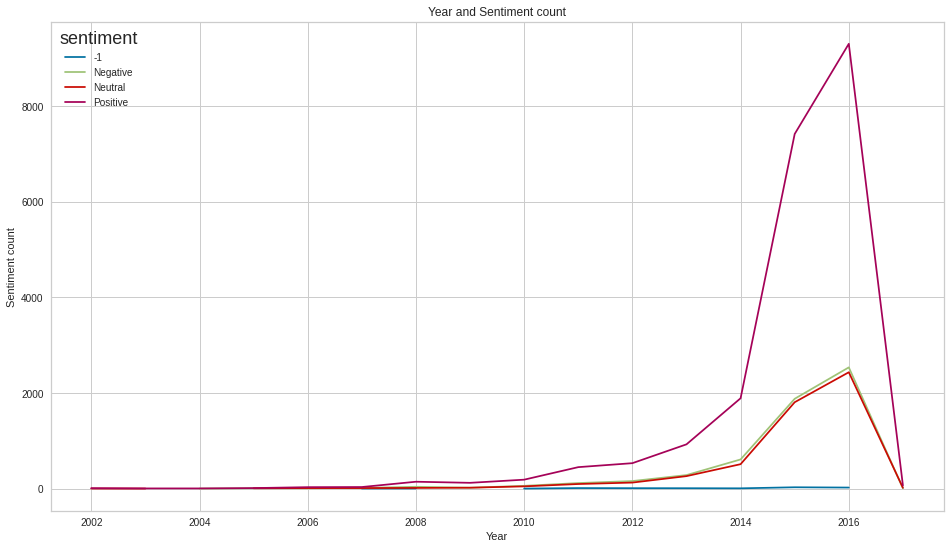

In [ ]:
data.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

**Analysis By Month**

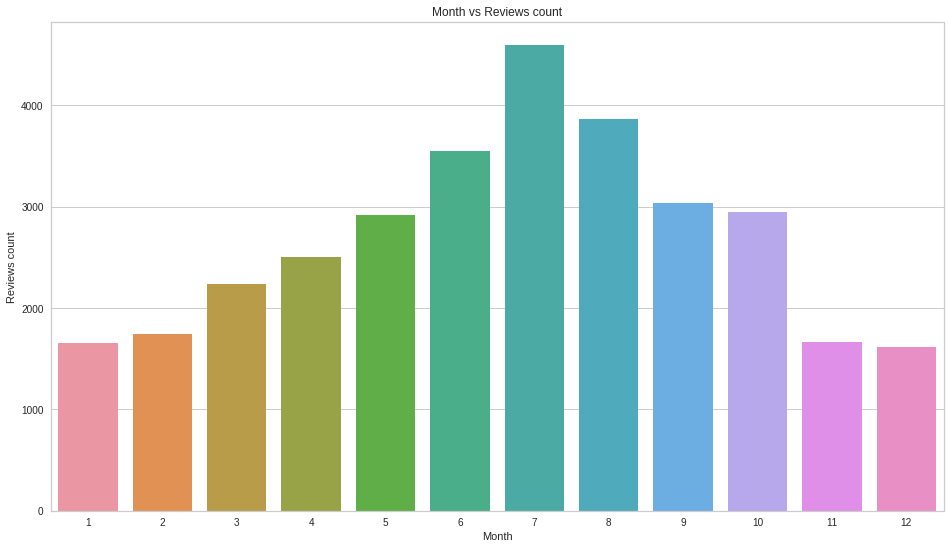

In [ ]:
#Creating a dataframe
day=pd.DataFrame(data.groupby('Month')['preprocessed'].count()).reset_index()
day['Month']=day['Month'].astype('int64')
day.sort_values(by=['Month'])

#Plotting the graph
sns.barplot(x="Month", y="preprocessed", data=day)
plt.title('Month vs Reviews count')
plt.xlabel('Month')
plt.ylabel('Reviews count')
plt.show()


In [ ]:
data['polarity'] = data['preprocessed'].map(lambda text: TextBlob(text).sentiment.polarity)
data['review_len'] = data['preprocessed'].astype(str).apply(len)
data['word_count'] = data['preprocessed'].apply(lambda x: len(str(x).split()))
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,city,name,reviews.rating,year,Month,time,preprocessed,sentiment,polarity,review_len,word_count
0,Mableton,Hotel Russo Palace,4.0,2013,09,00:00,pleasant min walk along sea front water bus re...,Positive,0.611111,150,23
1,Mableton,Hotel Russo Palace,5.0,2015,04,00:00,really lovely hotel stayed top floor surprised...,Positive,0.553571,164,24
3,Mableton,Hotel Russo Palace,5.0,2013,10,00:00,stayed four night october hotel staff welcomin...,Positive,0.305952,204,31
4,Mableton,Hotel Russo Palace,5.0,2015,03,00:00,stayed four night october hotel staff welcomin...,Positive,0.305952,204,31
5,Mableton,Hotel Russo Palace,5.0,2015,04,00:00,loved staying island lido need take water veni...,Positive,0.470000,203,32
...,...,...,...,...,...,...,...,...,...,...,...
35906,Gatlinburg,Elk Springs Resort,5.0,2016,05,00:00,time last weekend april stayed deer heart cabi...,Positive,0.256250,162,26
35907,Gatlinburg,Elk Springs Resort,5.0,2012,03,00:00,best best family stayed grin bear cabin christ...,Positive,0.675000,263,38
35908,Gatlinburg,Elk Springs Resort,5.0,2012,03,00:00,amazing vacation beautiful cabin stayed long w...,Positive,0.300000,184,28
35909,Gatlinburg,Elk Springs Resort,5.0,2015,11,00:00,husband stayed tree top bearfoot resort manage...,Positive,0.223948,920,136


**Frequency Distribution**

In [ ]:
from wordcloud import WordCloud,STOPWORDS
from collections import defaultdict
#Filtering data
review_pos = data[data["sentiment"]=='Positive'].dropna()
review_neu = data[data["sentiment"]=='Neutral'].dropna()
review_neg = data[data["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace
remove =['room','hotel','stay']
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["preprocessed"]:
    for word in generate_ngrams(sent):
        if word not in remove:
            freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["preprocessed"]:
    for word in generate_ngrams(sent):
        if word not in remove:
            freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["preprocessed"]:
    for word in generate_ngrams(sent):
        if word not in remove:
            freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["preprocessed"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["preprocessed"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["preprocessed"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')


/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



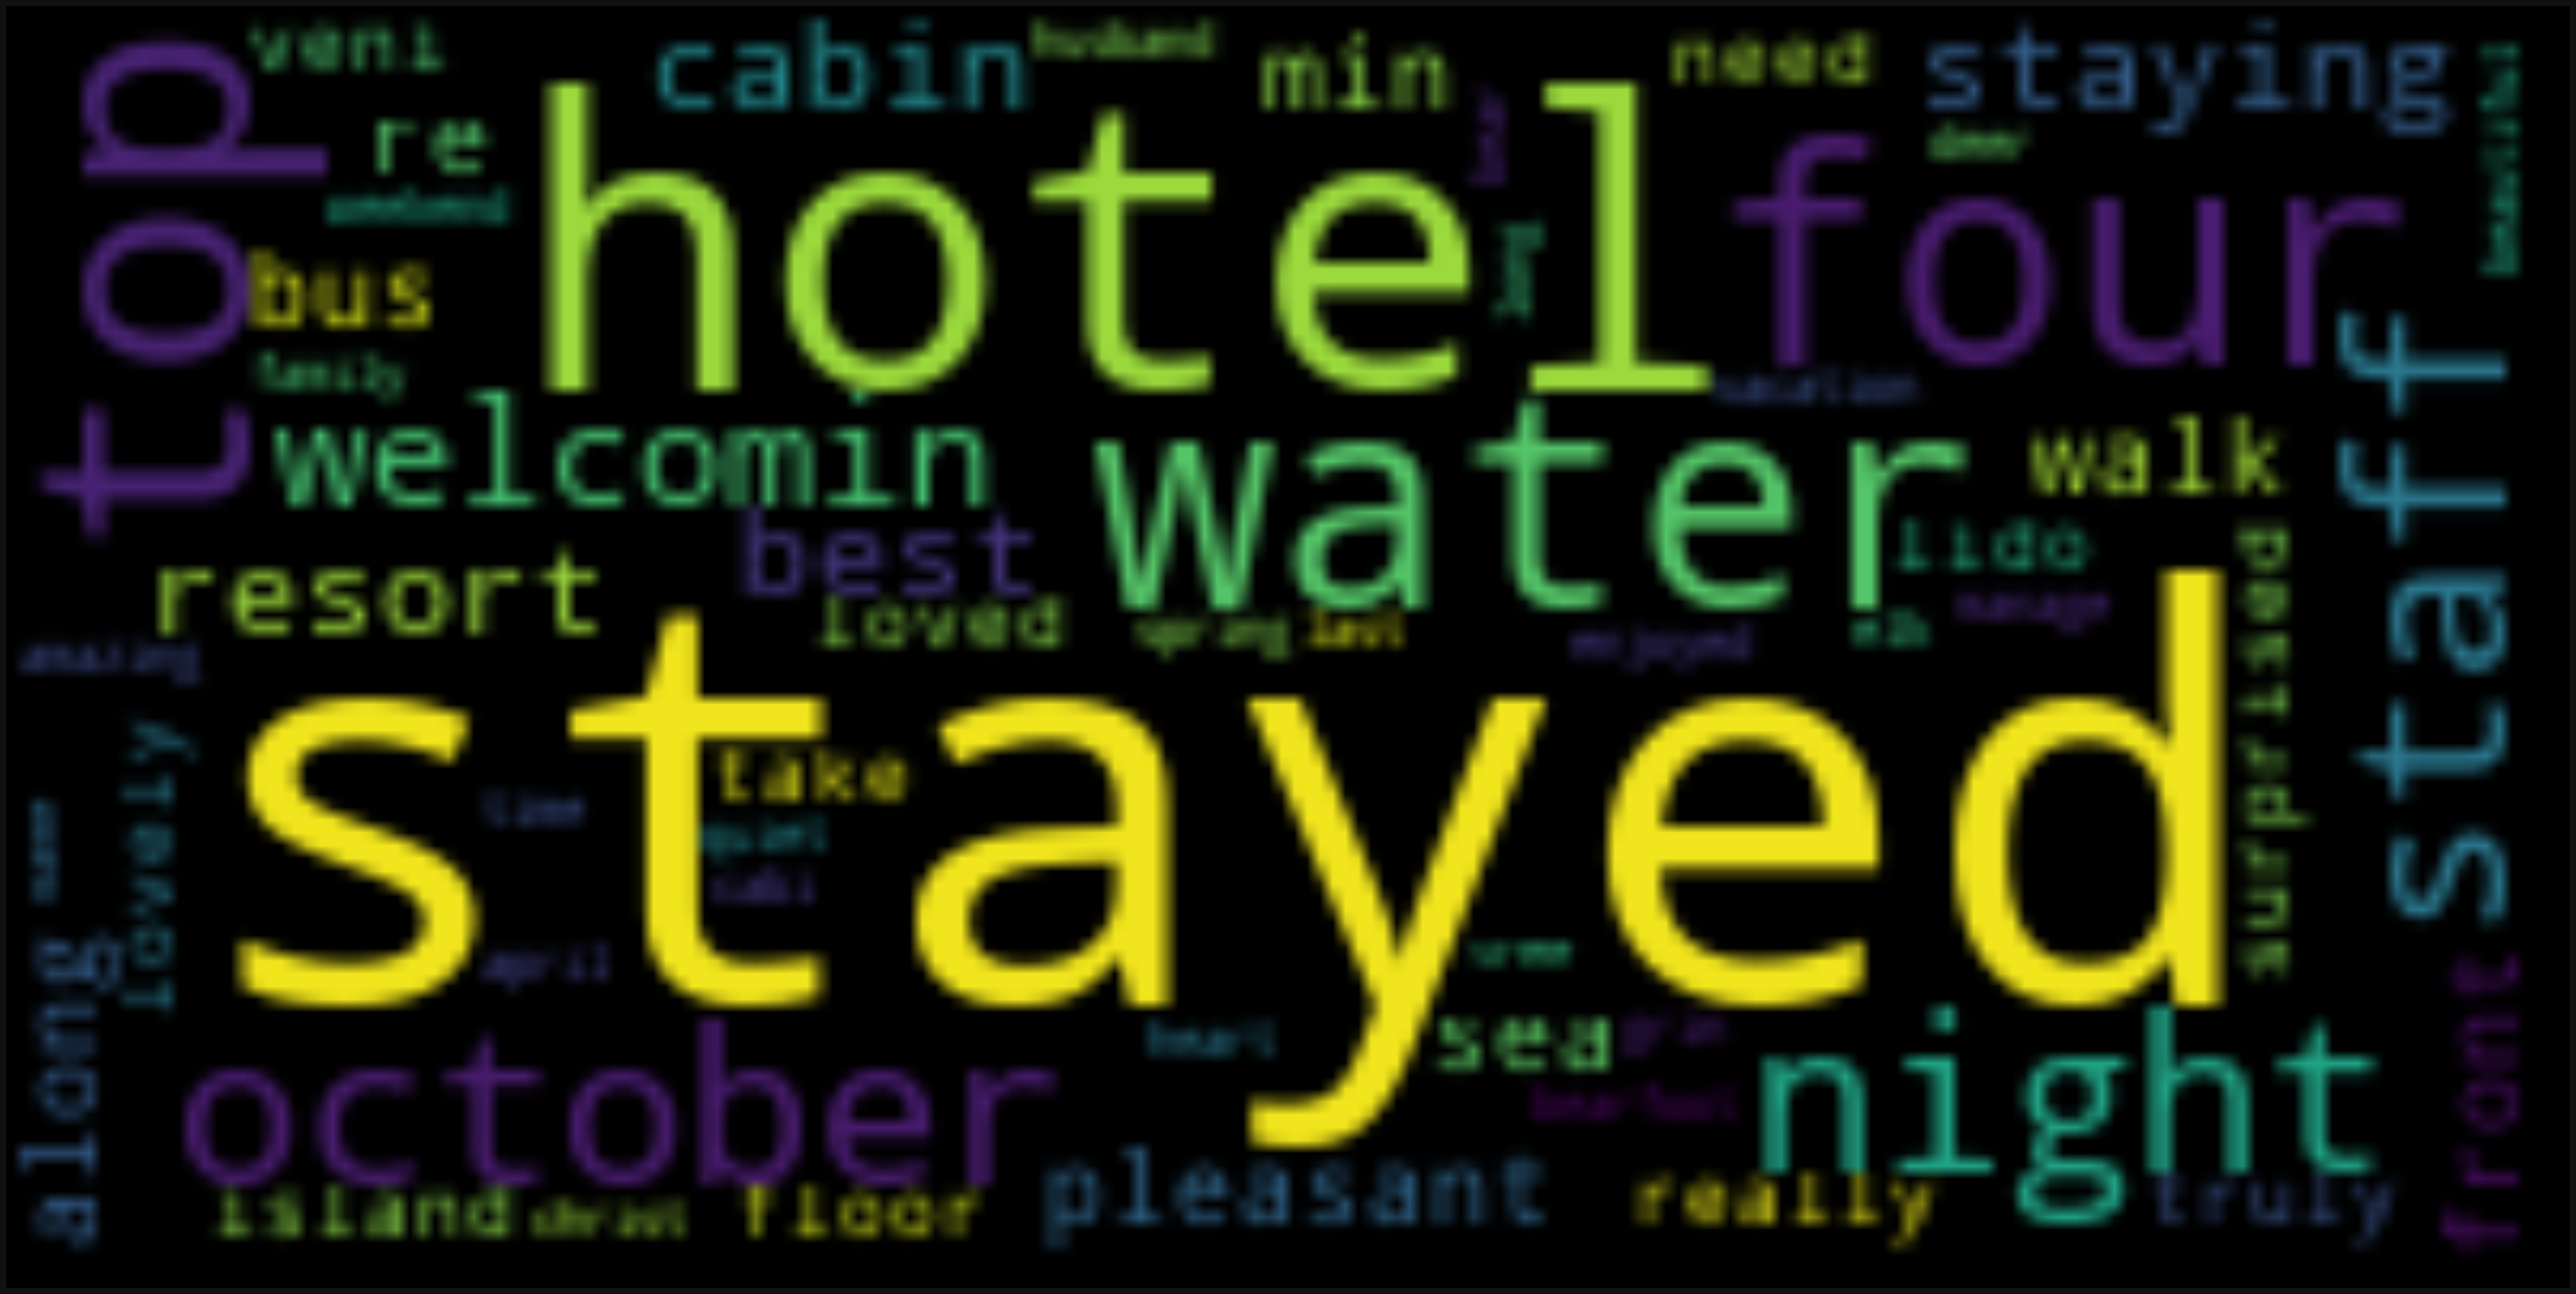

In [ ]:
text = review_pos["preprocessed"]
wordcloud = WordCloud(
    width = 200,
    height = 100,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
https://www.kaggle.com/benroshan/sentiment-analysis-amazon-reviews

SyntaxError: ignored

In [ ]:
from collections import Counter
def countFreq(text):
    for w in text.split(" "):
        if w not in wordfreq:
            wordfreq[w]=0
        else:
            wordfreq[w]+=1
    
wordfreq = {}
a = newdf['preprocessedStr'].apply(countFreq)
k = Counter(wordfreq)
high = k.most_common(20)
high

In [ ]:
# heating map, graph, to present.
# svm *
# frquency, rate,  
#

In [ ]:
# we should try this
# https://towardsdatascience.com/building-a-content-based-recommender-system-for-hotels-in-seattle-d724f0a32070

In [ ]:
#https://www.kaggle.com/chiranjeevbit/movie-review-prediction
# i tried it with our data and it works to give rate 1-5 but we have to modify it a lot. i think we can improve a lot here too
# I did the first draft for the sentiment. It seems the basic model is working, so I'll check on recommendation system.
#we still have to do
#tokenizer
#cleansing
#prof: You will of course have to try one or more methods for converting a variable-length document into a fixed-length feature representation to use as input to SVM etc.
#different method   -supervised(what we tried so far, and more)
#svm
#neural network(with tensor)
#unsupervised(https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483)
#with deeplearning (https://towardsdatascience.com/sentiment-analysis-for-text-with-deep-learning-2f0a0c6472b5)
#recommendation system (i think we can try different method too for this )